# scanpy
参考：https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering-2017.html

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import decoupler as dc

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

-----
anndata     0.10.9
scanpy      1.10.2
-----
PIL                         10.1.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.0
backcall                    0.2.0
bottleneck                  1.3.7
brotli                      1.1.0
certifi                     2023.07.22
cffi                        1.16.0
charset_normalizer          3.3.0
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.1.4
cycler                      0.12.1
cython_runtime              NA
cytoolz                     0.12.2
dask                        2023.10.0
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
decoupler                   1.7.0
defusedxml                  0.7.1
executing                   1.2.0
fastjsonschema              NA
fqdn                        

## データの読み込み

In [3]:
# データの読み込み
adata = sc.read_10x_mtx(
    "/home/work/data/2-2/filtered_feature_bc_matrix/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)
adata

AnnData object with n_obs × n_vars = 6776 × 19466
    var: 'gene_ids', 'feature_types'

In [4]:
# 重複した名前をユニークにする
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

AnnData object with n_obs × n_vars = 6776 × 19466
    var: 'gene_ids', 'feature_types'

In [5]:
# # adata.X：遺伝子数＊細胞数の遺伝子発現行列
# adata.X

In [6]:
# adata.obs：細胞名のdataframe
adata.obs.head()

""
AACAATCCGAGTGGAC-1
AACAATGGAACCACAT-1
AACACCAGCCTACTCG-1
AACACCATTCGCATAC-1
AACACCTAAGCATTGC-1


In [7]:
# # adata.var：遺伝子名のdataframe
# adata.var.head()

In [8]:
# 月齢の情報
age_month = pd.read_csv("/home/work/data/2-2/age_month.csv", index_col=0)
# age_month.head()

# adata.obsに月齢の情報を追加
# 新しい列を追加
adata.obs["age_month"] = age_month
adata.obs.head()

,age_month
AACAATCCGAGTGGAC-1,3
AACAATGGAACCACAT-1,2
AACACCAGCCTACTCG-1,2
AACACCATTCGCATAC-1,1
AACACCTAAGCATTGC-1,2


In [9]:
# 1月齢のデータだけ取り出す
# age列の値が1の行のインデックスを取得
index_age_1 = adata.obs[adata.obs["age_month"] == 1].index

# 条件に基づいてデータをフィルタリング
adata = adata[index_age_1, :]
adata

View of AnnData object with n_obs × n_vars = 1327 × 19466
    obs: 'age_month'
    var: 'gene_ids', 'feature_types'

## 前処理

### ミトコンドリア遺伝子の発現量でフィルタリング

In [10]:
# annotate the group of mitochondrial genes as "mt" → adata.varにミトコンドリア遺伝子か否かを示す"mt"列を追加
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# 遺伝子の平均発現量、発現している細胞の数、ミトコンドリア遺伝子発現量を計算？ → adata.varに列を追加
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

/tmp/ipykernel_1163/3569795936.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("MT-")


In [11]:
# adata.var.head()

/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When 

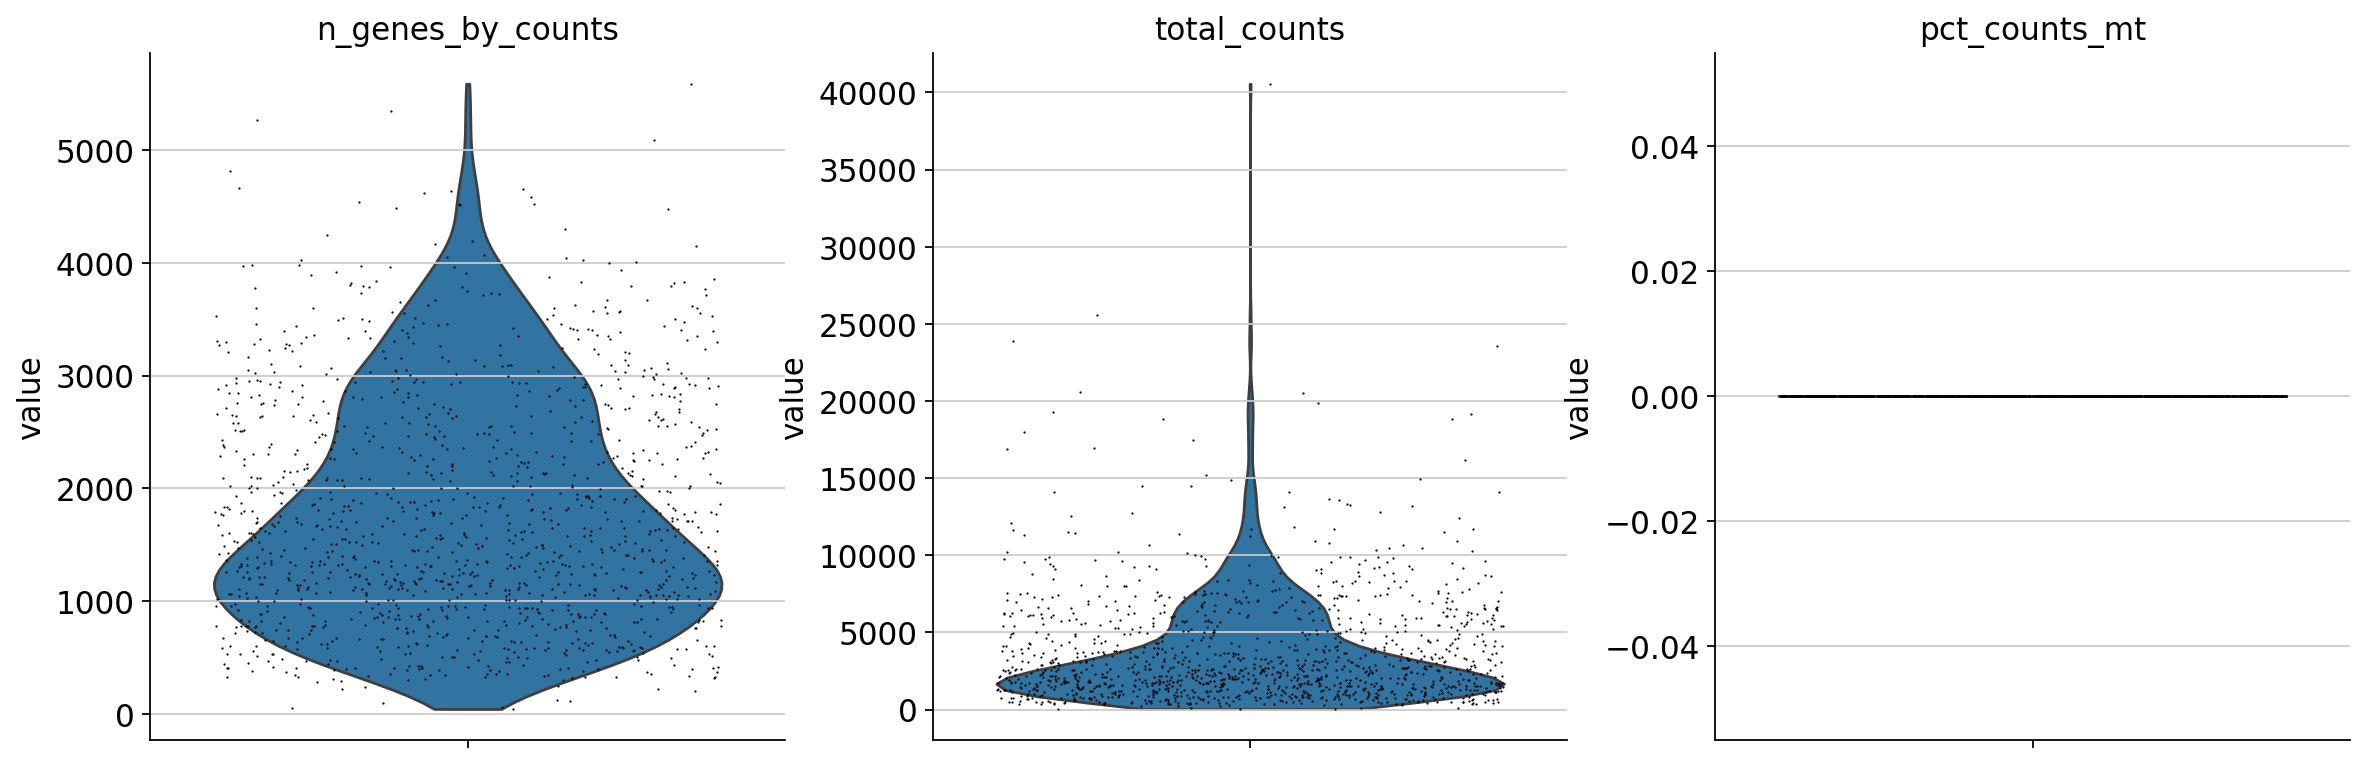

In [12]:
# バイオリンプロット
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

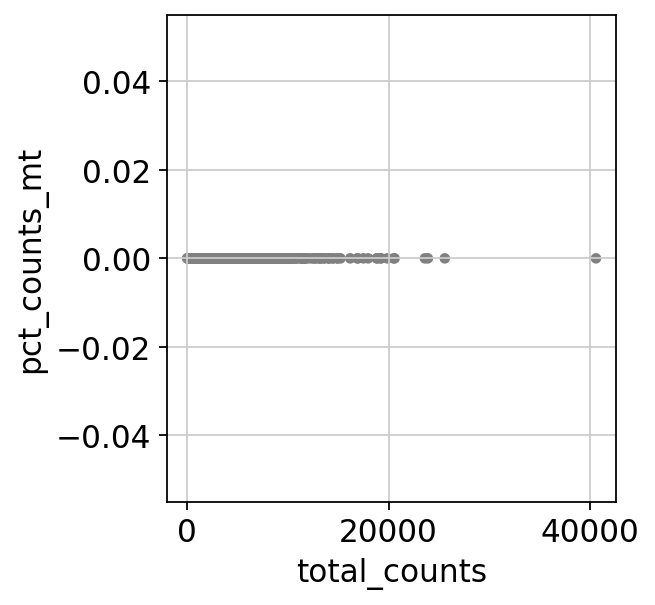

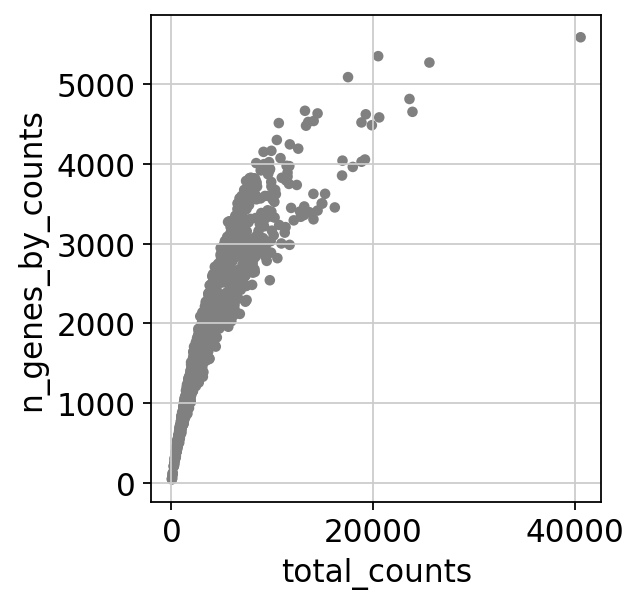

In [13]:
# 散布図
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [14]:
# # バイオリンプロットを見てフィルタリングする
# # 今回はフィルタリングされていそうなのでパス
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

### 細胞間でカウント数が比較できるように正規化

In [15]:
# 細胞あたり10000リードに正規化
sc.pp.normalize_total(adata, target_sum=1e4)

In [16]:
# logをとる
sc.pp.log1p(adata)

### 細胞間で発現に大きな変動がある遺伝子を探す

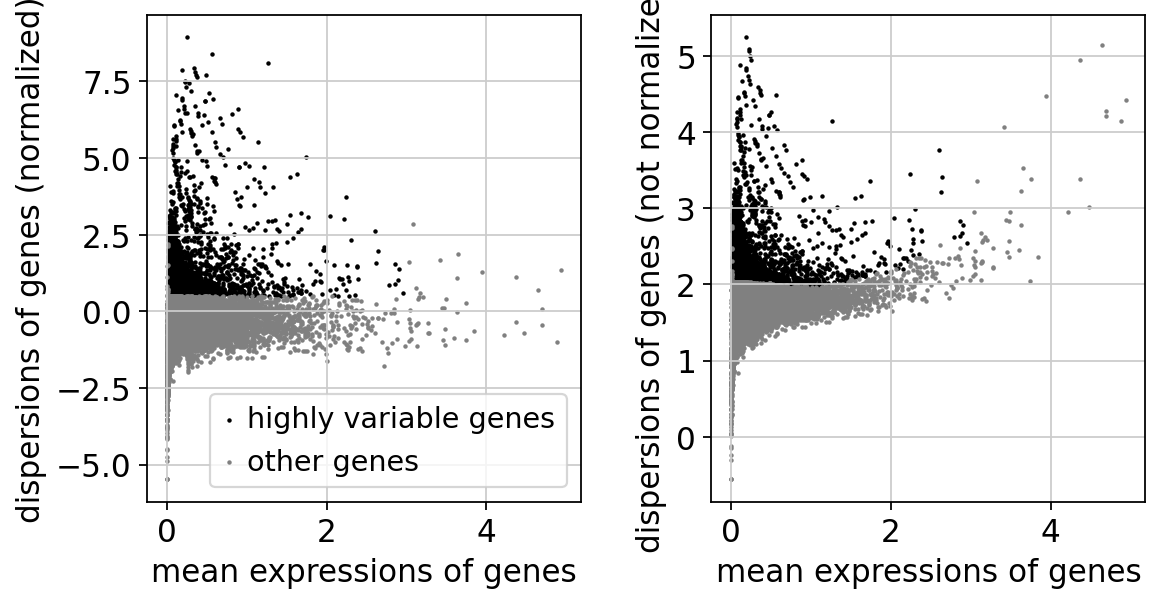

In [17]:
# 細胞間で発現に大きな変動がある遺伝子を探す
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# plot
sc.pl.highly_variable_genes(adata)

In [18]:
# adata.rawに現在のadataの状態を保存しておく
# 以降フィルタリングや正規化を行なっても.rawに元のデータが保存されている
adata.raw = adata

In [19]:
# 細胞間で発現に大きな変動がある遺伝子だけ取り出す
adata = adata[:, adata.var.highly_variable]

In [20]:
# 細胞あたりの総カウント数と発現したミトコンドリア遺伝子の割合の影響を除去する → よくわかってない
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

/opt/conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
# データを標準化する（平均を0、標準偏差を1にする）
sc.pp.scale(adata, max_value=10)

## PCA

### PCAによる次元削減、UMAPにつかう次元を決める

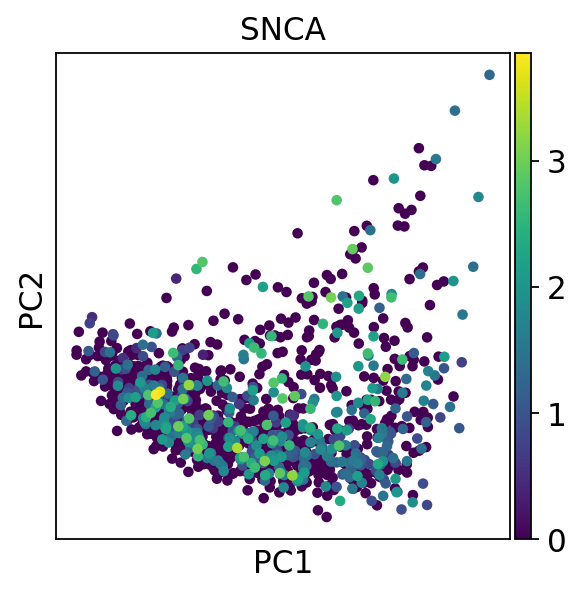

In [22]:
# PCA
sc.tl.pca(adata, svd_solver="arpack")
# plot
sc.pl.pca(adata, color='SNCA')

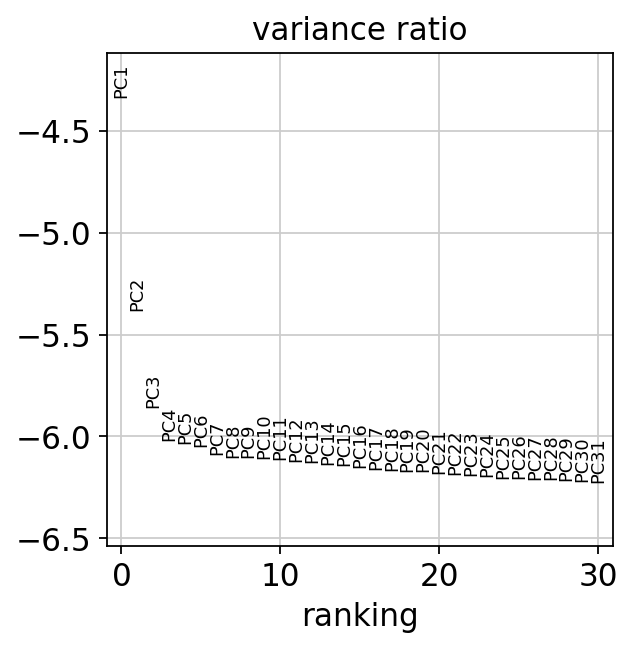

In [23]:
# PCの寄与率
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
# データを保存する
results_file = "/home/work/output/decoupler/mouse2-2-1.h5ad"  # the file that will store the analysis results
adata.write(results_file)

# # 読み込み
# adata = sc.read_h5ad("/home/work/output/decoupler/mouse2-2-1.h5ad")

In [25]:
adata

AnnData object with n_obs × n_vars = 1327 × 4553
    obs: 'age_month', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## 近傍グラフを計算（Computing the neighborhood graph）

In [26]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

## UMAPで二次元にプロット

In [27]:
sc.tl.umap(adata)

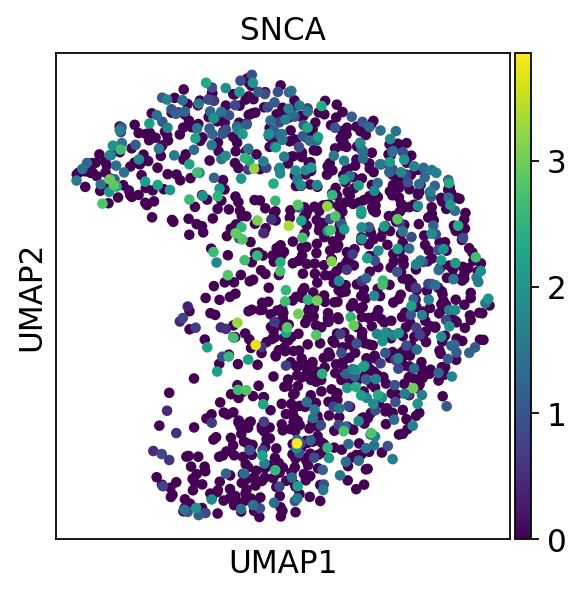

In [28]:
sc.pl.umap(adata, color="SNCA")

## Leiden clustering

/tmp/ipykernel_1163/1221674227.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1)


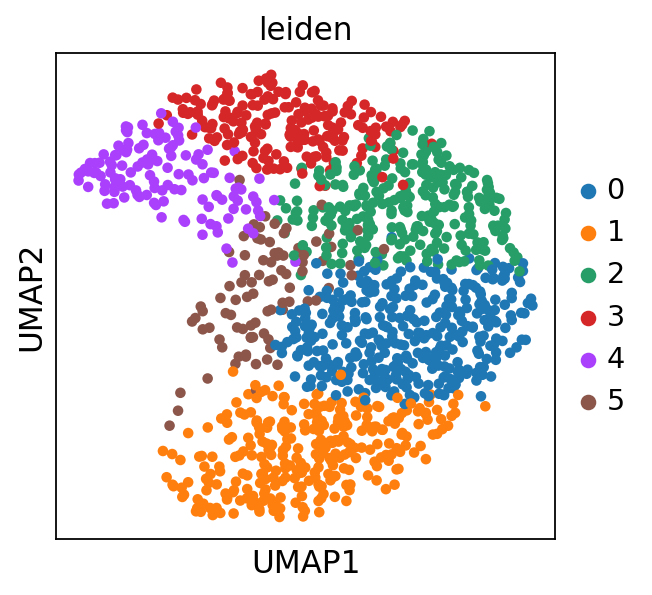

In [29]:
sc.tl.leiden(adata, resolution=1)
sc.pl.umap(adata, color="leiden")

In [30]:
# clusterの番号を出力
cluster = adata.obs["leiden"]
cluster.head()

cluster.to_csv("/home/work/output/decoupler/leiden_cluster_2-2-1_resl=1.csv")

### セルタイプアノテーション：decoupler

参考：https://decoupler-py.readthedocs.io/en/latest/notebooks/cell_annotation.html

In [31]:
# データベースをロード
markers = dc.get_resource('PanglaoDB')
markers.head()

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.000000,0.004394,True,0.003311,0.020480,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.000000,0.008420,True,0.000000,0.014915,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.005039,True,0.903226,0.012408,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.000000,0.008233,True,0.225806,0.013758,9606,Epithelium,0.013


In [32]:
# アノテーションに使う遺伝子を抜き出す
# 今回はマウスのデータなので、マウスの遺伝子だけ使う
markers = markers[markers['mouse'] & markers['canonical_marker'] & (markers['mouse_sensitivity'] > 0.5)]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers['genesymbol'] = markers['genesymbol'].str.capitalize()
markers.head()

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,Ctrb1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
7,Klk1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.000000,0.008202,True,1.000000,0.012914,9606,Immune system,0.013
23,Cela2a,True,Acinar cells,Endoderm,True,0.333333,0.000000,True,0.628571,0.002900,9606,Pancreas,0.005
26,Cela1,True,Acinar cells,Endoderm,True,0.000000,0.000000,True,0.814286,0.017467,9606,Pancreas,0.017
30,Amy2b,True,Acinar cells,Endoderm,True,0.083333,0.000000,True,0.528571,0.001482,9606,Pancreas,0.003


In [33]:
# degを取ってくる（各クラスタごと？）
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

Running ora on mat with 1327 samples and 4553 targets for 35 sources.


100%|██████████| 1327/1327 [00:02<00:00, 539.81it/s]


In [34]:
adata.obsm['ora_estimate']

source,Adipocytes,Astrocytes,Basophils,Beta cells,Cardiomyocytes,Chondrocytes,Dendritic cells,Embryonic stem cells,Endothelial cells,Fibroblasts,...,Pancreatic stellate cells,Pericytes,Plasma cells,Plasmacytoid dendritic cells,Platelets,Podocytes,Pulmonary alveolar type I cells,Schwann cells,Sertoli cells,Smooth muscle cells
AACACCATTCGCATAC-1,-0.0,1.253984,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.00000,-0.000000,...,-0.000000,-0.000000,3.116492,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000
AACACGACAACGGAGT-1,-0.0,-0.000000,1.470913,-0.000000,-0.000000,-0.000000,-0.0,1.177256,-0.00000,-0.000000,...,-0.000000,-0.000000,1.348437,-0.000000,-0.000000,-0.0,-0.000000,1.348437,-0.000000,1.253984
AACACGCAGATAACAA-1,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,3.116492,-0.0,1.177256,-0.00000,2.031945,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,1.253984
AACATAGAAGGTGAGT-1,-0.0,-0.000000,1.470913,-0.000000,1.112758,-0.000000,-0.0,-0.000000,-0.00000,0.858507,...,1.470913,-0.000000,1.348437,1.253984,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000
AACATAGAAGTGCGCA-1,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.00000,-0.000000,...,-0.000000,-0.000000,-0.000000,1.253984,-0.000000,-0.0,-0.000000,1.348437,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTCACCAAGAACGA-1,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,1.177256,1.05721,0.858507,...,-0.000000,1.470913,1.348437,-0.000000,-0.000000,-0.0,2.725106,1.348437,-0.000000,1.253984
TGTTCGCTTCTAATCC-1,-0.0,-0.000000,1.470913,1.470913,1.112758,-0.000000,-0.0,-0.000000,-0.00000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,0.965174,-0.0,-0.000000,1.348437,-0.000000,-0.000000
TGTTGCCGTTCGACCA-1,-0.0,-0.000000,-0.000000,-0.000000,1.112758,-0.000000,-0.0,1.177256,-0.00000,0.858507,...,1.470913,-0.000000,-0.000000,-0.000000,0.965174,-0.0,-0.000000,-0.000000,1.470913,9.734433
TGTTGGAGCCGCGACG-1,-0.0,-0.000000,1.470913,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.00000,2.031945,...,3.414241,-0.000000,1.348437,-0.000000,-0.000000,-0.0,2.725106,1.348437,-0.000000,-0.000000


In [35]:
# Visualization
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 1327 × 35
    obs: 'age_month', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

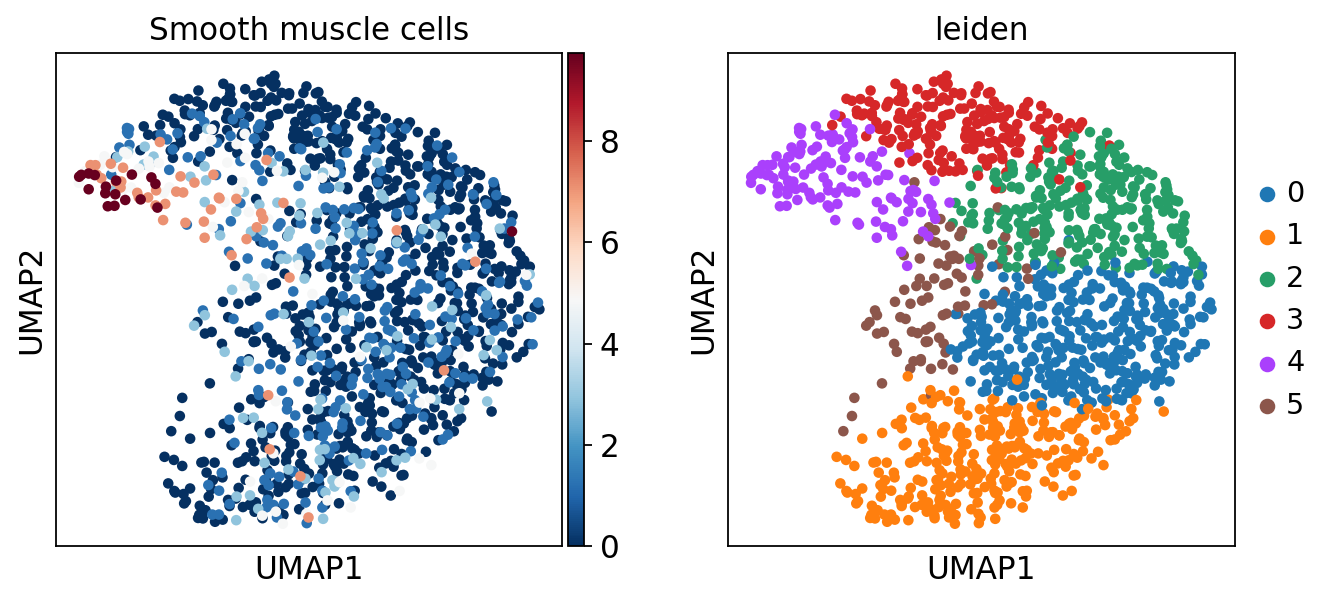

/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


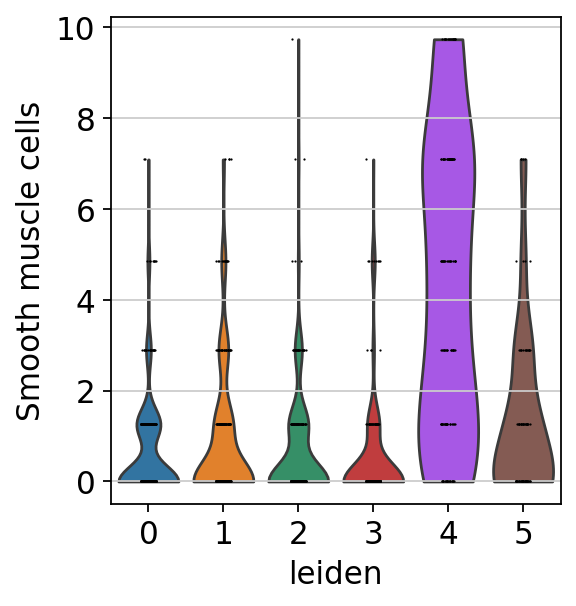

In [36]:
sc.pl.umap(acts, color=['Smooth muscle cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['Smooth muscle cells'], groupby='leiden')

In [37]:
# Annotation
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df.head()

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,Plasma cells,6.777643,0.557100,2.618980e-11,9.166430e-10
1,0,rest,Basophils,3.982603,0.255831,7.519460e-05,5.385294e-04
2,0,rest,Goblet cells,3.855882,0.353792,1.258170e-04,6.290852e-04
3,0,rest,Microglia,3.404852,0.183213,6.994355e-04,2.720027e-03
4,0,rest,Pulmonary alveolar type I cells,2.436912,0.178927,1.505691e-02,3.099953e-02


In [38]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'Plasma cells',
 '1': 'Pulmonary alveolar type I cells',
 '2': 'Plasma cells',
 '3': 'Chondrocytes',
 '4': 'Smooth muscle cells',
 '5': 'Basophils'}

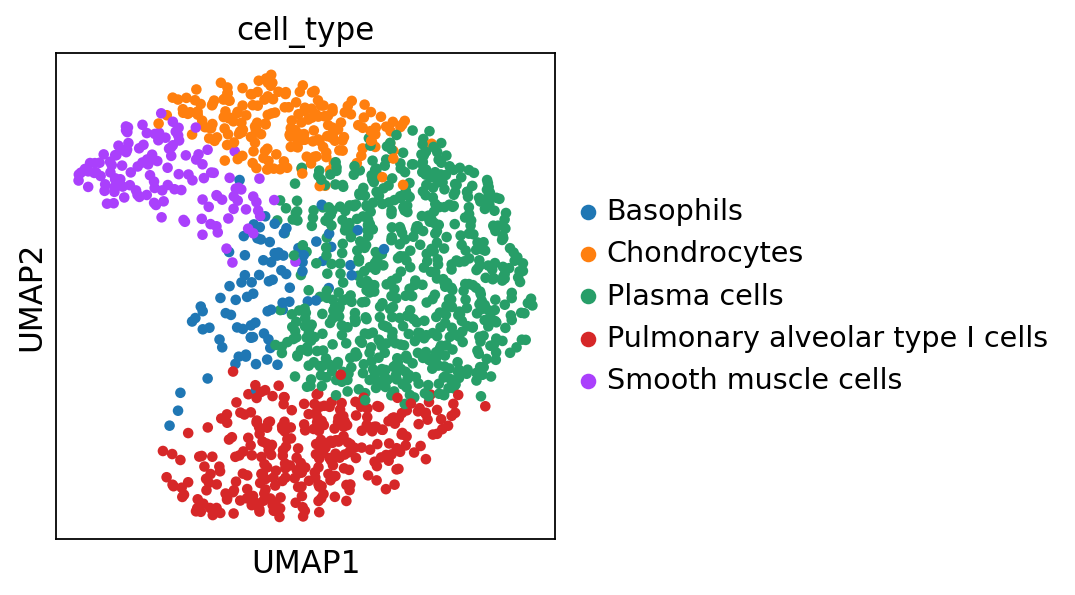

In [39]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')

In [40]:
adata.obs.head()

,age_month,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type
AACACCATTCGCATAC-1,1,3794,11355.0,0.0,0.0,0,Plasma cells
AACACGACAACGGAGT-1,1,472,624.0,0.0,0.0,0,Plasma cells
AACACGCAGATAACAA-1,1,2093,4575.0,0.0,0.0,0,Plasma cells
AACATAGAAGGTGAGT-1,1,2968,7271.0,0.0,0.0,0,Plasma cells
AACATAGAAGTGCGCA-1,1,4634,14488.0,0.0,0.0,2,Plasma cells


In [41]:
# clusterの番号を出力
cluster = adata.obs["cell_type"]
cluster.head()

cluster.to_csv("/home/work/output/decoupler/cell_type_cluster_2-2-1_resl=1.csv")